In [64]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [79]:
import os
from glob import glob
from pathlib import Path

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotx
import pandas as pd
from fastcore.xtras import load_pickle
from scipy.stats import sem

from gptchem.evaluator import find_learning_curve_intersection, fit_learning_curve, lc
from gptchem.plotsettings import *
from gptchem.settings import ONE_COL_WIDTH_INCH, TWO_COL_GOLDEN_RATIO_HEIGHT_INCH

In [80]:
all_out = glob("out/**/*.pkl")

In [81]:
all_modnet_out = glob("out_baseline/*.pkl")

In [82]:
len(all_modnet_out)

63

In [83]:
len(all_out)

22

In [70]:
all_res = [load_pickle(p) for p in all_out]

In [71]:
all_compiled_res = []
all_compiled_baseline_res = []

for res in all_res:
    compiled_res = {}
    compiled_baseline_res = {}
    compiled_res["accuracy"] = res["accuracy"]
    compiled_res["f1_macro"] = res["f1_macro"]
    compiled_res["f1_micro"] = res["f1_micro"]
    compiled_res["kappa"] = res["kappa"]
    compiled_res["train_size"] = res["train_size"]

    try:
        compiled_baseline_res["accuracy"] = res["baseline"]["accuracy"]
        compiled_baseline_res["f1_macro"] = res["baseline"]["f1_macro"]
        compiled_baseline_res["f1_micro"] = res["baseline"]["f1_micro"]
        compiled_baseline_res["kappa"] = res["baseline"]["kappa"]
        compiled_baseline_res["train_size"] = res["train_size"]
    except KeyError:
        compiled_baseline_res["accuracy"] = None
        compiled_baseline_res["f1_macro"] = None
        compiled_baseline_res["f1_micro"] = None
        compiled_baseline_res["kappa"] = None
        compiled_baseline_res["train_size"] = res["train_size"]

    all_compiled_res.append(compiled_res)

    if compiled_baseline_res["accuracy"] is not None:
        if compiled_baseline_res["accuracy"] < 1:
            all_compiled_baseline_res.append(compiled_baseline_res)

In [72]:
all_modnet_res = []

for res in all_modnet_out:
    all_modnet_res.append(load_pickle(res))

In [73]:
all_compiled_res = pd.DataFrame(all_compiled_res)
all_compiled_baseline_res = pd.DataFrame(all_compiled_baseline_res)
all_modnet_res = pd.DataFrame(all_modnet_res)

In [74]:
grouped_res = all_compiled_res.groupby("train_size").agg(["mean", "std", sem])

In [75]:
grouped_automatminer = all_compiled_baseline_res.groupby("train_size").agg(["mean", "std", sem])

/Users/kevinmaikjablonka/miniconda3/envs/gptchem/lib/python3.9/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/kevinmaikjablonka/miniconda3/envs/gptchem/lib/python3.9/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/kevinmaikjablonka/miniconda3/envs/gptchem/lib/python3.9/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/kevinmaikjablonka/miniconda3/envs/gptchem/lib/python3.9/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/kevinmaikjablonka/miniconda3/envs/gptchem/lib/python3.9/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _va

In [76]:
grouped_modnet = (
    all_modnet_res[["accuracy", "f1_macro", "f1_micro", "kappa", "train_size"]]
    .groupby("train_size")
    .agg(["mean", "std", sem])
)

In [77]:
grouped_modnet

accuracy                      f1_macro                      \
                mean       std       sem      mean       std       sem   
train_size                                                               
10          0.652974  0.059564  0.017959  0.564138  0.048966  0.014764   
50          0.703037  0.025252  0.007985  0.623190  0.041504  0.013125   
100         0.713864  0.022039  0.006645  0.647704  0.020937  0.006313   
200         0.746417  0.012815  0.003864  0.693404  0.012274  0.003701   
500         0.784977  0.011775  0.003550  0.733352  0.014694  0.004430   
1000        0.807170  0.008597  0.002866  0.764303  0.009657  0.003219   

            f1_micro                         kappa                      
                mean       std       sem      mean       std       sem  
train_size                                                              
10          0.652974  0.059564  0.017959  0.135915  0.102145  0.030798  
50          0.703037  0.025252  0.007985  0.249037  0.080955  0.025600  
100         0.713864  0.022039  0.006645  0.296913  0.041788  0.012600  
200         0.746417  0.012815  0.003864  0.387587  0.024670  0.007438  
500         0.784977  0.011775  0.003550  0.467472  0.028935  0.008724  
1000        0.807170  0.008597  0.002866  0.528903  0.019217  0.006406

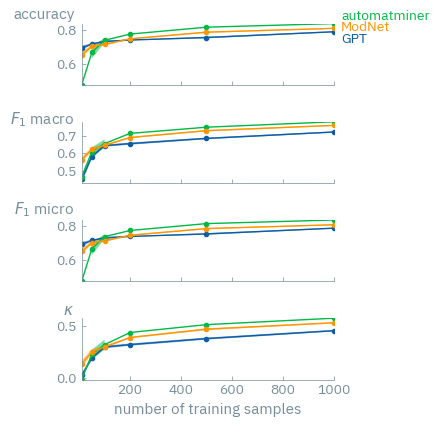

In [78]:
fig, ax = plt.subplots(
    4, 1, figsize=(ONE_COL_WIDTH_INCH, TWO_COL_GOLDEN_RATIO_HEIGHT_INCH), sharex=True
)

ax[0].plot(
    grouped_res.index,
    grouped_res["accuracy"]["mean"],
    label="GPT",
    marker="o",
)

ax[0].fill_between(
    grouped_res.index,
    grouped_res["accuracy"]["mean"] - grouped_res["accuracy"]["sem"],
    grouped_res["accuracy"]["mean"] + grouped_res["accuracy"]["sem"],
    alpha=0.5,
)

ax[0].plot(
    grouped_automatminer.index,
    grouped_automatminer["accuracy"]["mean"],
    label="automatminer",
    marker="o",
)

ax[0].fill_between(
    grouped_automatminer.index,
    grouped_automatminer["accuracy"]["mean"] - grouped_automatminer["accuracy"]["sem"],
    grouped_automatminer["accuracy"]["mean"] + grouped_automatminer["accuracy"]["sem"],
    alpha=0.5,
)
ax[0].plot(
    grouped_modnet.index,
    grouped_modnet["accuracy"]["mean"],
    label="ModNet",
    marker="o",
)

ax[0].fill_between(
    grouped_modnet.index,
    grouped_modnet["accuracy"]["mean"] - grouped_modnet["accuracy"]["sem"],
    grouped_modnet["accuracy"]["mean"] + grouped_modnet["accuracy"]["sem"],
    alpha=0.5,
)

matplotx.line_labels(ax[0])

ylabel_top("accuracy", ax[0])

ax[1].plot(
    grouped_res.index,
    grouped_res["f1_macro"]["mean"],
    label="GPT",
    marker="o",
)
ax[1].fill_between(
    grouped_res.index,
    grouped_res["f1_macro"]["mean"] - grouped_res["f1_macro"]["sem"],
    grouped_res["f1_macro"]["mean"] + grouped_res["f1_macro"]["sem"],
    alpha=0.5,
)

ax[1].plot(
    grouped_automatminer.index,
    grouped_automatminer["f1_macro"]["mean"],
    label="automatminer",
    marker="o",
)
ax[1].fill_between(
    grouped_automatminer.index,
    grouped_automatminer["f1_macro"]["mean"] - grouped_automatminer["f1_macro"]["sem"],
    grouped_automatminer["f1_macro"]["mean"] + grouped_automatminer["f1_macro"]["sem"],
    alpha=0.5,
)

ax[1].plot(
    grouped_modnet.index,
    grouped_modnet["f1_macro"]["mean"],
    label="ModNet",
    marker="o",
)
ax[1].fill_between(
    grouped_modnet.index,
    grouped_modnet["f1_macro"]["mean"] - grouped_modnet["f1_macro"]["sem"],
    grouped_modnet["f1_macro"]["mean"] + grouped_modnet["f1_macro"]["sem"],
    alpha=0.5,
)

ylabel_top(r"$F_1$ macro", ax[1])

ax[2].plot(
    grouped_res.index,
    grouped_res["f1_micro"]["mean"],
    label="GPT",
    marker="o",
)
ax[2].fill_between(
    grouped_res.index,
    grouped_res["f1_micro"]["mean"] - grouped_res["f1_micro"]["sem"],
    grouped_res["f1_micro"]["mean"] + grouped_res["f1_micro"]["sem"],
    alpha=0.5,
)

ax[2].plot(
    grouped_automatminer.index,
    grouped_automatminer["f1_micro"]["mean"],
    label="automatminer",
    marker="o",
)
ax[2].fill_between(
    grouped_automatminer.index,
    grouped_automatminer["f1_micro"]["mean"] - grouped_automatminer["f1_micro"]["sem"],
    grouped_automatminer["f1_micro"]["mean"] + grouped_automatminer["f1_micro"]["sem"],
    alpha=0.5,
)

ax[2].plot(
    grouped_modnet.index,
    grouped_modnet["f1_micro"]["mean"],
    label="ModNet",
    marker="o",
)
ax[2].fill_between(
    grouped_modnet.index,
    grouped_modnet["f1_micro"]["mean"] - grouped_modnet["f1_micro"]["sem"],
    grouped_modnet["f1_micro"]["mean"] + grouped_modnet["f1_micro"]["sem"],
    alpha=0.5,
)

ylabel_top(r"$F_1$ micro", ax[2])

ax[3].plot(
    grouped_res.index,
    grouped_res["kappa"]["mean"],
    label="GPT",
    marker="o",
)
ax[3].fill_between(
    grouped_res.index,
    grouped_res["kappa"]["mean"] - grouped_res["kappa"]["sem"],
    grouped_res["kappa"]["mean"] + grouped_res["kappa"]["sem"],
    alpha=0.5,
)

ax[3].plot(
    grouped_automatminer.index,
    grouped_automatminer["kappa"]["mean"],
    label="automatminer",
    marker="o",
)
ax[3].fill_between(
    grouped_automatminer.index,
    grouped_automatminer["kappa"]["mean"] - grouped_automatminer["kappa"]["sem"],
    grouped_automatminer["kappa"]["mean"] + grouped_automatminer["kappa"]["sem"],
    alpha=0.5,
)

ax[3].plot(
    grouped_modnet.index,
    grouped_modnet["kappa"]["mean"],
    label="ModNet",
    marker="o",
)
ax[3].fill_between(
    grouped_modnet.index,
    grouped_modnet["kappa"]["mean"] - grouped_modnet["kappa"]["sem"],
    grouped_modnet["kappa"]["mean"] + grouped_modnet["kappa"]["sem"],
    alpha=0.5,
)

ylabel_top(r"$\kappa$", ax[3])

plt.subplots_adjust(hspace=0.6, top=1, bottom=0.2)

ax[-1].set_xlabel("number of training samples")

fig.savefig("glass_lc.pdf", bbox_inches="tight")

In [84]:
find_learning_curve_intersection(
    grouped_res["f1_macro"]["mean"].values[0],
    fit_learning_curve(
        grouped_automatminer.index,
        grouped_automatminer["f1_macro"]["mean"],
    )[0],
) / 10

0.9818986881113947

In [88]:
find_learning_curve_intersection(
    grouped_res["f1_macro"]["mean"].values[0],
    fit_learning_curve(
        grouped_modnet.index,
        grouped_modnet["f1_macro"]["mean"],
    )[0],
) / 10

0.6208750717446352